# Callin Switzer
___

### 16 Jan 2020
### - Train without pruning
### - Then prune


___

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rc('font',family='Times New Roman')
from matplotlib.ticker import ScalarFormatter
import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
#import winsound
import pickle
import glob
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = os.getcwd()
#dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = '/home/olivia/mothML/mothMachineLearning_dataAndFigs/Figs/'
dataOutput = '/home/olivia/mothML/mothMachineLearning_dataAndFigs/DataOutput/'
savedModels = '/home/olivia/mothML/mothMachineLearning_dataAndFigs/savedModels/'
dataDir = '/home/olivia/mothML/mothMachineLearning_dataAndFigs/PythonGeneratedData_oneTorque/'
if not os.path.exists(figDir):
    os.mkdir(figDir)

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0] 

last run on 2020-04-29 11:14:11.203906


In [2]:
tf.VERSION

'1.13.1'

In [3]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


# Make training and test set

In [4]:
# get table names in database
con1 = sqlite3.connect(os.path.join(dataDir, "oneTorqueData.db"))
cursorObj = con1.cursor()
res = cursorObj.execute("SELECT name FROM sqlite_master WHERE type='table';")
tableNames = [name[0] for name in res]
con1.close()
print(tableNames)

['test', 'train']


In [5]:
con1 = sqlite3.connect(os.path.join(dataDir, "oneTorqueData.db"))
trainDF = pd.read_sql_query("SELECT * FROM train", con1)
testDF = pd.read_sql_query("SELECT * FROM test", con1)
con1.close()

In [6]:
# double check for repeats!
np.sum(trainDF.iloc[:, [16,17,18]].duplicated()) # 0 means no repeats

0

In [7]:
print(trainDF.shape)
trainDF.head()

(10000000, 19)


,x_0,xd_0,y_0,yd_0,theta_0,thetad_0,phi_0,phid_0,x_f,xd_f,y_f,yd_f,theta_f,thetad_f,phi_f,phid_f,F,alpha,tau0
0,0.0,1127.569064,0.0,765.895323,1.075898,11.962440,3.427385,18.462602,18.323331,716.627905,14.965420,553.784155,2.653195,147.068401,5.115222,153.187791,41181.992912,1.987846,-63216.237665
1,0.0,979.651081,0.0,-625.561275,0.306688,-5.637037,2.576453,19.788635,18.603118,878.261004,-13.758388,-732.267264,0.102441,-34.254744,2.372751,-34.214230,9062.020340,3.567122,19108.940596
2,0.0,1111.257777,0.0,-1406.672066,5.094943,16.102668,1.775724,-9.188076,19.014000,1058.629029,-25.108839,-1007.321715,2.811424,-218.672246,-0.370204,-211.787743,42727.993224,4.104033,49781.327507
3,0.0,-1438.730397,0.0,690.882986,5.034187,-3.375327,5.534301,-9.669100,-31.101504,-1501.738112,10.625933,331.290367,6.319507,141.205184,6.795796,140.443097,28953.145279,4.698031,92261.347215
4,0.0,1370.322727,0.0,-216.459775,4.186927,-16.500337,3.194818,-0.385905,27.276171,1358.779274,-4.544002,-238.613391,3.984840,-10.035763,3.181642,-0.756667,371.601599,0.668810,-40259.257246


In [8]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

# rename columns to be consistent with other code
testDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [9]:
# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

testDF["Fx"] = testDF.F * np.cos(testDF.alpha)
testDF["Fy"] = testDF.F * np.sin(testDF.alpha)


In [10]:
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

# make test dataset
Xtest = testDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Ytest = testDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [11]:
X.head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,3.427385,1.075898,18.323331,14.965420,5.115222,2.653195,1127.569064,765.895323,18.462602,11.962440
1,2.576453,0.306688,18.603118,-13.758388,2.372751,0.102441,979.651081,-625.561275,19.788635,-5.637037
2,1.775724,5.094943,19.014000,-25.108839,-0.370204,2.811424,1111.257777,-1406.672066,-9.188076,16.102668
3,5.534301,5.034187,-31.101504,10.625933,6.795796,6.319507,-1438.730397,690.882986,-9.669100,-3.375327
4,3.194818,4.186927,27.276171,-4.544002,3.181642,3.984840,1370.322727,-216.459775,-0.385905,-16.500337


In [12]:
Y.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,-16681.383440,37652.197635,-63216.237665,716.627905,553.784155,153.187791,147.068401
1,-8253.874132,-3740.825371,19108.940596,878.261004,-732.267264,-34.214230,-34.254744
2,-24419.876370,-35062.102662,49781.327507,1058.629029,-1007.321715,-211.787743,-218.672246
3,-415.702991,-28950.160838,92261.347215,-1501.738112,331.290367,140.443097,141.205184
4,291.543841,230.412537,-40259.257246,1358.779274,-238.613391,-0.756667,-10.035763


In [13]:
# val train split
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [14]:
# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xval_scaled = scalerX.transform(Xval)
Yval_scaled = scalerY.transform(Yval)


# final test data
Xtest_scaled = scalerX.transform(Xtest)

In [15]:
pd.DataFrame(Xtrain_scaled, columns = X.columns).head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,0.440808,-0.497541,-0.376881,-0.092528,0.279106,-0.125546,-0.413733,-0.087276,0.151751,-0.419563
1,0.002656,0.450960,0.232234,0.301146,-0.030380,0.180345,0.276074,0.383212,0.227138,0.094672
2,0.302116,0.217276,0.364791,-0.175444,-0.008066,-0.047502,0.385703,-0.188919,-0.266187,-0.202705
3,-0.471247,0.121804,0.070077,0.310735,-0.319397,-0.062783,0.103501,0.332100,-0.227711,0.447327
4,-0.350056,-0.349031,0.313582,0.159721,-0.093290,-0.092005,0.350805,0.216431,0.136925,0.270457


# Keras models

In [16]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers
from keras.initializers import Identity
from keras.initializers import Zeros

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

K.clear_session()

In [17]:
# create network
def create_network(optimizer = 'rmsprop', 
                    numUnits = [400, 16], 
                    weightRegularization = 0.0, 
                    dropout_rate=0.1):
    
    '''
    Create a feed forward network.  Assumes Xtrain & Ytrain have been created and scaled
    
    Params: 
    optimizer (str): choice of optimizer
    numUnits (list): number of units in each hidden
    weightRegularization (float): between 0 and 1
    dropout_rate (float): between 0 and 1
    
    '''
    K.clear_session()
    inputs = Input(shape=(Xtrain_scaled.shape[1],))    
    
    # add layers
    for ii in np.arange(0, len(numUnits)):
        if ii >= 1: 
            x = Dense(numUnits[ii], activation='tanh', 
                      kernel_regularizer=regularizers.l1(weightRegularization))(x)
            x = Dense(numUnits[ii], kernel_initializer='identity',bias_initializer='zeros',
                      trainable=False)(x)

        else: 
            x = Dense(numUnits[ii], activation='tanh')(inputs)
            x = Dense(numUnits[ii], kernel_initializer='identity',bias_initializer='zeros',
                      trainable=False)(x)


        # add dropout
        if dropout_rate > 0: 
            x = Dropout(dropout_rate)(x)
    
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [18]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]


earlystop = EarlyStopping(monitor='val_mse', patience=50, 
                          verbose=1, mode='auto', min_delta = 0.000001)

In [19]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history.history['val_mean_squared_error'][-1])))
    axs.set_ylabel('Mean squared error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(0,len(model_history.history['val_mean_squared_error']), 50), 50)
    axs.legend(['train', 'validation'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + ".pdf"), dpi = 500, bbox_inches='tight')
    
    plt.show()

    
def plot_model_history_fromDict(model_history_dictionary, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history_dictionary['mean_squared_error'])+1),
             model_history_dictionary['mean_squared_error'])
    axs.plot(range(1,len(model_history_dictionary['val_mean_squared_error'])+1),
             model_history_dictionary['val_mean_squared_error'], alpha = 0.7)
    axs.set_title('Model MSE = '+ str(format_e(model_history_dictionary['val_mean_squared_error'][-1])))
    axs.set_ylabel('Mean squared error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(0,len(model_history_dictionary['val_mean_squared_error']), 50),50)
    axs.legend(['train', 'validation'], loc=2)
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"), dpi = 120, bbox_inches='tight')
        print(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"))


___

In [19]:
# train and trim weights

In [35]:

K.clear_session()

modelParams = {"optimizer": "rmsprop", 
              "dropout_rate" : 0, 
               "numUnits": [400, 400, 400, 16],
               "weightRegularization": 0
              }


model = create_network(**modelParams)

modeltimestamp = datetime.now().strftime("%Y_%m_%d__%I_%M_%S")
modelName = ''.join('{}_{}__'.format(key[0:3].capitalize(), val) for  key, val in modelParams.items()).\
                            replace("[", "").replace("]", "").replace(", ", "_")[0:-2] + "_" + modeltimestamp
print(modelName)

model.summary()

Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_04_28__11_24_12
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               4400      
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_5 (Dense)              (None, 400)               160400    
__________________________________________________________

In [36]:
# # save scalers, to be used on test set
scalerfileX = 'scalerX_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

scalerfileY = 'scalerY_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

In [37]:
# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

In [39]:
# train without pruning
history = model.fit(Xtrain_scaled, Ytrain_scaled, 
                    validation_data=(Xval_scaled, Yval_scaled), 
                    callbacks = [earlystop],
                    verbose = 2, batch_size=2**12, epochs = 1000)

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1000
 - 15s - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 2/1000
 - 14s - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 3/1000
 - 15s - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/1000
 - 14s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 5/1000
 - 14s - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 6/1000
 - 14s - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 7/1000
 - 14s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 8/1000
 - 14s - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 9/1000
 - 14s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 10/1000
 - 13s - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 11/1000
 - 14s - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0018 - val_mse: 0.001

Epoch 85/1000
 - 14s - loss: 5.9792e-04 - mse: 5.9792e-04 - val_loss: 7.9968e-04 - val_mse: 7.9968e-04
Epoch 86/1000
 - 14s - loss: 5.9492e-04 - mse: 5.9492e-04 - val_loss: 6.0789e-04 - val_mse: 6.0789e-04
Epoch 87/1000
 - 14s - loss: 5.9178e-04 - mse: 5.9178e-04 - val_loss: 6.9048e-04 - val_mse: 6.9048e-04
Epoch 88/1000
 - 14s - loss: 5.8923e-04 - mse: 5.8923e-04 - val_loss: 8.5732e-04 - val_mse: 8.5732e-04
Epoch 89/1000
 - 14s - loss: 5.8613e-04 - mse: 5.8613e-04 - val_loss: 4.9930e-04 - val_mse: 4.9930e-04
Epoch 90/1000
 - 14s - loss: 5.8360e-04 - mse: 5.8360e-04 - val_loss: 8.2417e-04 - val_mse: 8.2417e-04
Epoch 91/1000
 - 15s - loss: 5.8092e-04 - mse: 5.8092e-04 - val_loss: 6.0435e-04 - val_mse: 6.0435e-04
Epoch 92/1000
 - 15s - loss: 5.7891e-04 - mse: 5.7890e-04 - val_loss: 4.8455e-04 - val_mse: 4.8455e-04
Epoch 93/1000
 - 15s - loss: 5.7630e-04 - mse: 5.7630e-04 - val_loss: 6.6894e-04 - val_mse: 6.6894e-04
Epoch 94/1000
 - 14s - loss: 5.7366e-04 - mse: 5.7366e-04 - val_loss: 6.7

Epoch 164/1000
 - 14s - loss: 4.6515e-04 - mse: 4.6515e-04 - val_loss: 5.4359e-04 - val_mse: 5.4359e-04
Epoch 165/1000
 - 14s - loss: 4.6485e-04 - mse: 4.6485e-04 - val_loss: 5.6139e-04 - val_mse: 5.6139e-04
Epoch 166/1000
 - 15s - loss: 4.6324e-04 - mse: 4.6324e-04 - val_loss: 5.8678e-04 - val_mse: 5.8678e-04
Epoch 167/1000
 - 14s - loss: 4.6255e-04 - mse: 4.6255e-04 - val_loss: 6.5414e-04 - val_mse: 6.5414e-04
Epoch 168/1000
 - 14s - loss: 4.6188e-04 - mse: 4.6188e-04 - val_loss: 8.3968e-04 - val_mse: 8.3968e-04
Epoch 169/1000
 - 14s - loss: 4.6144e-04 - mse: 4.6144e-04 - val_loss: 4.2188e-04 - val_mse: 4.2188e-04
Epoch 170/1000
 - 15s - loss: 4.5928e-04 - mse: 4.5928e-04 - val_loss: 5.3177e-04 - val_mse: 5.3177e-04
Epoch 171/1000
 - 14s - loss: 4.5957e-04 - mse: 4.5957e-04 - val_loss: 4.9006e-04 - val_mse: 4.9006e-04
Epoch 172/1000
 - 14s - loss: 4.5828e-04 - mse: 4.5828e-04 - val_loss: 4.1777e-04 - val_mse: 4.1777e-04
Epoch 173/1000
 - 14s - loss: 4.5800e-04 - mse: 4.5800e-04 - val

Epoch 243/1000
 - 14s - loss: 4.1502e-04 - mse: 4.1503e-04 - val_loss: 3.8811e-04 - val_mse: 3.8811e-04
Epoch 244/1000
 - 14s - loss: 4.1456e-04 - mse: 4.1456e-04 - val_loss: 3.7409e-04 - val_mse: 3.7409e-04
Epoch 245/1000
 - 14s - loss: 4.1375e-04 - mse: 4.1376e-04 - val_loss: 4.0758e-04 - val_mse: 4.0758e-04
Epoch 246/1000
 - 14s - loss: 4.1368e-04 - mse: 4.1368e-04 - val_loss: 6.1305e-04 - val_mse: 6.1305e-04
Epoch 247/1000
 - 15s - loss: 4.1360e-04 - mse: 4.1360e-04 - val_loss: 3.3876e-04 - val_mse: 3.3876e-04
Epoch 248/1000
 - 14s - loss: 4.1234e-04 - mse: 4.1234e-04 - val_loss: 4.6590e-04 - val_mse: 4.6590e-04
Epoch 249/1000
 - 14s - loss: 4.1224e-04 - mse: 4.1224e-04 - val_loss: 4.8460e-04 - val_mse: 4.8460e-04
Epoch 250/1000
 - 15s - loss: 4.1237e-04 - mse: 4.1237e-04 - val_loss: 4.0555e-04 - val_mse: 4.0555e-04
Epoch 251/1000
 - 14s - loss: 4.1153e-04 - mse: 4.1153e-04 - val_loss: 4.1469e-04 - val_mse: 4.1469e-04
Epoch 252/1000
 - 15s - loss: 4.1189e-04 - mse: 4.1189e-04 - val

In [27]:
print(history.history.keys())

dict_keys(['val_loss', 'val_mse', 'loss', 'mse'])


In [40]:
# save history
historyDict["mean_squared_error"].extend(history.history["mse"])
historyDict["val_mean_squared_error"].extend(history.history["val_mse"])

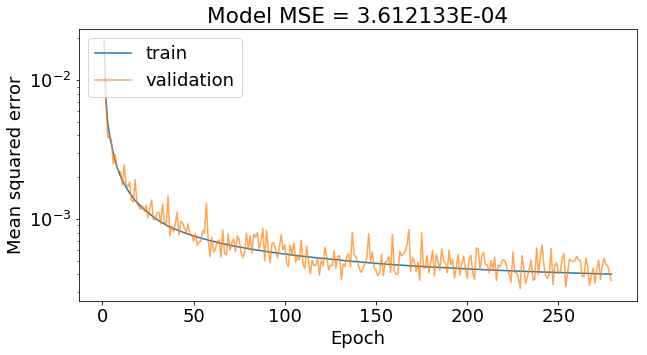

In [41]:
plot_model_history_fromDict(historyDict)

In [42]:
# save model
model.save(os.path.join(savedModels,  modelName + '.h5'))

# save weights
wts = model.get_weights().copy()

wtsFile = modelName + '_wts.pkl'
pickle.dump(wts, open(os.path.join(dataOutput, wtsFile), 'wb'))

# save history with same name as model
historyFile = modeltimestamp + '_history.pkl'
pickle.dump(historyDict, open(os.path.join(dataOutput, historyFile), 'wb'))

In [43]:
#  plot error rates on test data

In [44]:
# predict on test set
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(Ytest, columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()


,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,Fx_pred,Fy_pred,tau_pred,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred
0,-5342.432439,14670.842555,-57718.558932,-577.070011,-1317.410003,-76.817401,-84.515766,-7085.740723,14457.892578,-57541.304688,-570.500610,-1254.564453,-78.849548,-83.988701
1,-2515.747661,3418.036434,-64775.342625,-18.839022,1292.672193,17.808851,1.199298,-1376.909912,4469.265137,-62687.253906,38.271351,1305.388062,11.703015,-0.834052
2,-6497.950980,-17669.503572,-49237.798014,-1094.713883,-1469.532303,124.939700,115.462788,-7874.136230,-19301.236328,-54264.441406,-1067.191650,-1377.519043,130.384338,119.540764
3,24237.433019,-8489.629561,56490.932254,-187.441953,-427.573908,100.329900,100.827942,25359.298828,-7585.224609,63842.718750,-233.050262,-450.957336,109.238113,108.826149
4,1782.839206,5791.542006,26503.920442,625.069923,31.217768,-26.216617,-20.827598,1685.470825,4378.611328,32201.980469,649.700745,73.121872,-16.402761,-13.319962


In [30]:
#df_c = df_c.iloc[:1000, :]

# df_c = df_c.replace([np.inf, -np.inf], np.nan)
# df_c = df_c.replace([np.inf, -np.inf], np.nan).dropna()

In [20]:
import matplotlib.ticker as mtick
import matplotlib
class MathTextSciFormatter(mtick.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            return(" ")
        return "${}$".format(s)

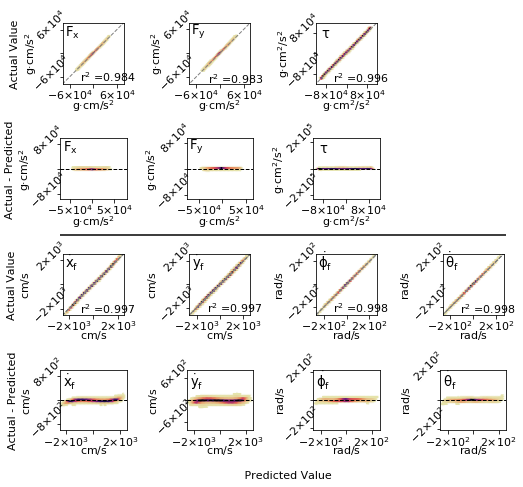

In [34]:
# make plots
from sklearn.metrics import r2_score
from matplotlib import ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 11})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.transforms as mtrans


fig_col_names = [r'$F_x$', r'$F_y$', r'$\tau$', r'$\dot{x}_f$', r'$\dot{y}_f$', r'$\dot{\phi}_f$', r'$\dot{\theta}_f$']

plt.close("all")
fig, axs = plt.subplots(4,4, figsize=np.array([8, 7.5]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.9, wspace=.9)
# fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r'$g·cm/s^2$', "$g·cm/s^2$", "$g·cm^2/s^2$", "$cm/s$", "$cm/s$", "$rad/s$", "$rad/s$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
# make really low-value hexbins white
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, 3):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].set_yticklabels(axs[ii].get_yticklabels(), 
                            rotation = 45, ha="center",
                            va = "bottom", rotation_mode="anchor")
    axs[ii].yaxis.set_label_coords(-0.4,0.5)
    axs[ii].set_xlabel(ylabs[ii] + "\n")
    axs[ii].xaxis.set_label_coords(0.5,-0.2)
    axs[ii].tick_params(axis="x",direction="out", pad=-0)
    

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].set_title(fig_col_names[ii], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[ii].title
    ttl.set_position([.15, 0.62])
    
    # draw identity lines
    lims = [
        np.min([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # min of both axes
        np.max([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # max of both axes
        ]
    axs[ii].plot(lims, lims,  
                 'grey', linewidth = 1, linestyle  = "--")
#     axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
#                  df_c.loc[:,YtestDF.columns[ii]], 
#                  'grey', linewidth = 1, linestyle  = "--")
    axs[ii].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].set_aspect('equal', 'box')

    # annotate with R^2
    axs[ii].text(np.max(lims)*-0.4, 
                 np.min(lims)*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])
    axs[ii].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(4, 7)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.2)
    
    if jj == 3:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                      Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])
        
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.62])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
#####
#### Part 2
#####

#fig.subplots_adjust(hspace = 0.9, wspace=.9)

# Plot y = actual, x = predicted
for plotnum, dataColNum in zip(np.arange(8,12), np.arange(3, 7)):
    axs[plotnum].hexbin(y = df_c.loc[:,YtestDF.columns[dataColNum]],
                   x = df_c.loc[:,YpredDF.columns[dataColNum]], 
                   gridsize = 50, cmap = cmap)
    axs[plotnum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].set_yticklabels(axs[plotnum].get_yticklabels(),
                                 rotation = 45, ha="center",
                                 va = "bottom", rotation_mode="anchor")
    axs[plotnum].yaxis.set_label_coords(-0.5,0.5)
    axs[plotnum].set_xlabel(ylabs[dataColNum] + "\n")
    axs[plotnum].xaxis.set_label_coords(0.5,-0.2)

    if(plotnum == 8):
        axs[plotnum].set_ylabel("Actual Value\n" + ylabs[dataColNum])
    else:
        axs[plotnum].set_ylabel(ylabs[dataColNum])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[plotnum].set_title(fig_col_names[dataColNum], 
                           fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotnum].title
    ttl.set_position([.15, 0.60])
    axs[plotnum].plot(df_c.loc[:,YtestDF.columns[dataColNum]], 
                 df_c.loc[:,YtestDF.columns[dataColNum]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[plotnum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].set_aspect('equal', 'box')

    # annotate with R^2
    axs[plotnum].text(np.max(df_c.loc[:,YtestDF.columns[dataColNum]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[dataColNum]])*0.85, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[dataColNum]],  
                                        df_c.loc[:,YpredDF.columns[dataColNum]])), 3)))
    axs[plotnum].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    axs[plotnum].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    
    axs[plotnum].tick_params(axis="x",direction="out", pad=-0)

# residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
# refref Here
for jj, plotNum in zip(np.arange(3, 7), np.arange(12, 16)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.2)
    
    if jj == 4:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                                       Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 3):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.55])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
    
axs[3].axis('off')
axs[7].axis('off')

# add black horizontal line
ax3 = plt.figure(1).add_subplot(111)
ax3.plot([-1,1],[0.48,0.48], '-', color = "black" )
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.axis("off")

#plt.tight_layout()
#fig.savefig(os.path.join(figDir, "PredVActual" + modelName + ".pdf"),)
plt.show()
# plt.close()

In [45]:
## Pruning
modelName

'Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_04_28__11_24_12'

In [21]:
# load model
from keras.models import load_model

K.clear_session()


modelName =  "Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_04_28__11_24_12"
modeltimestamp = "2020_04_28__11_24_12"
model = load_model(os.path.join(savedModels,  modelName + ".h5"))

# load weights
wtsFile = modelName + '_wts.pkl'
wts = pickle.load(open(os.path.join(dataOutput, wtsFile), 'rb'))

# load history with same name as model
historyFile = modeltimestamp + '_history.pkl'
historyDict = pickle.load(open(os.path.join(dataOutput, historyFile), 'rb'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


(array([1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00,
        2.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00,
        2.00000e+00, 3.00000e+00, 0.00000e+00, 3.00000e+00, 1.00000e+00,
        2.00000e+00, 4.00000e+00, 6.00000e+00, 1.00000e+01, 7.00000e+00,
        7.00000e+00, 1.10000e+01, 1.70000e+01, 2.00000e+01, 2.00000e+01,
        2.20000e+01, 2.50000e+01, 2.30000e+01, 3.60000e+01, 4.20000e+01,
        5.30000e+01, 7.30000e+01, 9.50000e+01, 1.05000e+02, 1.80000e+02,
        3.01000e+02, 5.15000e+02, 1.02300e+03, 3.44900e+03, 1.49616e+05,
        2.07400e+03, 8.03000e+02, 4.23000e+02, 2.60000e+02, 1.55000e+02,
        1.23000e+02, 9.40000e+01, 7.20000e+01, 5.30000e+01, 4.20000e+01,
        2.70000e+01, 3.70000e+01, 2.00000e+01, 2.00000e+01, 1.90000e+01,
        1.70000e+01, 9.00000e+00, 6.00000e+00, 7.00000e+00, 9.00000e+00,
        6.00000e+00, 4.00000e+00, 4.00000e+00, 2.00

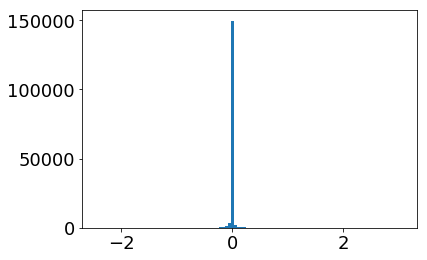

In [30]:
test = wts[4].reshape(160000,1)
plt.hist(test,bins=100)

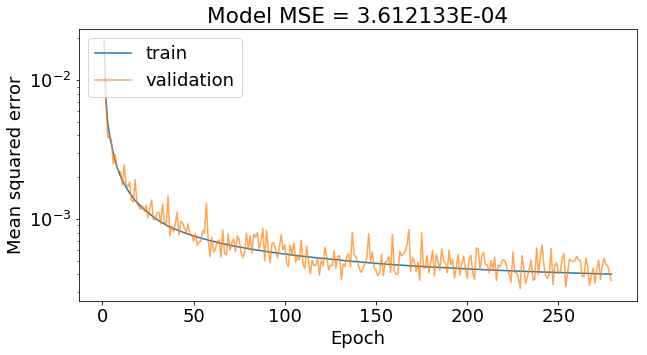

In [23]:
plt.rcParams.update({'font.size': 18})
plot_model_history_fromDict(historyDict)

In [105]:
from numpy.linalg import inv
wtsInv = inv(wts[0])

LinAlgError: Last 2 dimensions of the array must be square

In [56]:
np.arange(0,len(wts),2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16])

In [106]:
# train with pruning
numCuts = 1

wts = model.get_weights()
wtLengths = []
for ii in np.arange(0,len(wts),2):
    wtLengths.append(np.prod(wts[ii].shape))

In [104]:
wtLengths

[4000,
 400,
 160000,
 400,
 160000,
 400,
 160000,
 400,
 160000,
 400,
 160000,
 400,
 6400,
 16,
 256,
 16,
 112,
 7]

In [91]:
wtsAndBias = model.get_weights().copy()
# use .copy so that the weights will change when trained 

wtsWorking = []

for i in np.arange(0, len(wtsAndBias), 2):
    wtsWorking.append(wtsAndBias[i])

In [102]:
# Take the inverse of all the wqeights and save as wtsInv

wtsInv = []
# c

for i in np.arange(1, len(wtsWorking), 2):
    wtsWorking[i].reshape(int(np.sqrt(wtLengths[i])),int(np.sqrt(wtLengths[i])))
    wtsInv.append(inv(wtsWorking[i]))

In [ ]:
# Will give me [sparse weights] but will not set weights in model to [sparse weights]. Can use model.setweights 

for ii in np.arange(0, len(wts), 2):
    qants = np.percentile(np.reshape(wts[ii], -1), 
                          q = (50 - cutPercent[numCuts],
                               50 + cutPercent[numCuts]), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

In [56]:


# make new folder to save each prune
modelSubdir = os.path.join(savedModels, modeltimestamp + "_checkpoints")
if not os.path.exists(modelSubdir):
    os.mkdir(modelSubdir)

In [40]:
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
def prune_percent_updater(x):
    logit = np.exp(x*8) / (np.exp(x*8) + 1)
    return((logit - 0.5)*2*50)

# cuts a smaller portion as the percent gets closer to 100%
cutPercent = prune_percent_updater(np.linspace(0, 1, 26))

print(cutPercent*2)

[ 0.         15.86485043 30.95069212 44.62436102 56.48995528 66.40367703
 74.42768674 80.75689166 85.64849155 89.36977272 92.16685544 94.25030081
 95.7917306  96.92645889 97.75871874 98.36748577 98.81189556 99.1358533
 99.37175734 99.54340943 99.66823978 99.75898315 99.82492807 99.87284121
 99.90764768 99.93292997]


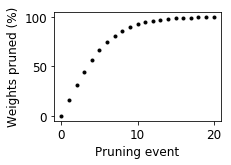

In [41]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=[3,2])
plt.plot((cutPercent*2)[0:21], ".", color = "black")
plt.xlabel("Pruning event")
plt.ylabel("Weights pruned (%)")
plt.savefig(os.path.join(figDir, "pruningPercentages.pdf"), bbox_inches='tight')

In [42]:
(cutPercent*2)[0:21]

array([ 0.        , 15.86485043, 30.95069212, 44.62436102, 56.48995528,
       66.40367703, 74.42768674, 80.75689166, 85.64849155, 89.36977272,
       92.16685544, 94.25030081, 95.7917306 , 96.92645889, 97.75871874,
       98.36748577, 98.81189556, 99.1358533 , 99.37175734, 99.54340943,
       99.66823978])

In [44]:
overallEpochCounter = len(historyDict['mean_squared_error'])
print(overallEpochCounter)

while True:   
   
    for numEpocs in range(100):
        
        MSE_tmp = []

        history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                            verbose = 2, batch_size=2**12, epochs = 1)
        
        overallEpochCounter += 1
        
        # save history
        historyDict["mean_squared_error"].append(history.history["mse"][0])
        historyDict["val_mean_squared_error"].append(history.history["val_mse"][0])
        
        # local MSE
        MSE_tmp.append(history.history["mse"][0])

        # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
        # get nonzero weights
        wts = model.get_weights().copy()
        
        # This is not ignoring the biases. It is also setting them to zero. 

        # set weights close to 0 to 0 (but ignore biases)
        for ii in np.arange(0, len(wts), 1):
            qants = np.percentile(np.reshape(wts[ii], -1), 
                                  q = (50 - cutPercent[numCuts], 
                                       50 + cutPercent[numCuts]), )
            wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

        # print nonzero weights
        # calculate number of nonzero weights
        nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
        print(nzwts, "of", np.sum(wtLengths), "weights retained")

        # set new weights and calculate new loss
        model.set_weights(wts)
        
        # check the change in mean squared error, and if it's not changing much, then cut out more data
        # calculate slope of loss, based on previous 5 data points
        if numEpocs > 5:
            inputData = historyDict["mean_squared_error"][-5:]

            m = np.shape(inputData)
            X = np.matrix([np.ones(m), np.arange(0, len(inputData))]).T
            y = np.matrix(np.log(inputData)).T

            # Solve for projection matrix
            intercept, slope = np.array(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)).reshape(-1,)
            print("change in log loss:", slope)
    
            # break if slope has stopped changing or if the overall min has been surpassed
            # in the first training, it will automatically prune after 5 epochs, because the min will be passed
            if (np.abs(slope) < 0.0001) or (history.history["mse"][0] < np.min(historyDict["mean_squared_error"][:-1])): 
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                
                # save model
                model.save(os.path.join(savedModels,  modelSubdir, modelName + str(overallEpochCounter) + '_Pruned.h5'))
                
                
                # save weights
                wts = model.get_weights().copy()

                wtsFile = str(overallEpochCounter) + "_" + modelName + '_wts.pkl'
                pickle.dump(wts, open(os.path.join(savedModels, modelSubdir, wtsFile), 'wb'))

                # save history with same name as model
                historyFile = modeltimestamp + '_history.pkl'
                pickle.dump(historyDict, open(os.path.join(savedModels,modelSubdir, historyFile), 'wb'))
                
                numCuts += 1                
                break

    if numCuts >= len(cutPercent):
        break

        
        #cutPercent += 0.2
#winsound.PlaySound("*", winsound.SND_ALIAS)

750
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.2489e-04 - mse: 3.2489e-04 - val_loss: 3.3985e-04 - val_mse: 3.3985e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.2483e-04 - mse: 3.2483e-04 - val_loss: 4.2538e-04 - val_mse: 4.2538e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.2500e-04 - mse: 3.2500e-04 - val_loss: 3.0355e-04 - val_mse: 3.0355e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.2482e-04 - mse: 3.2482e-04 - val_loss: 3.6833e-04 - val_mse: 3.6833e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.2459e-04 - mse: 3.2459e-04 - val_loss: 4.8400e-04 - val_mse: 4.8400e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1

 - 11s - loss: 3.2526e-04 - mse: 3.2526e-04 - val_loss: 3.5934e-04 - val_mse: 3.5934e-04
111458 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.2471e-04 - mse: 3.2471e-04 - val_loss: 4.1998e-04 - val_mse: 4.1998e-04
111458 of 331735 weights retained
change in log loss: -0.0005310058593752665
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.2485e-04 - mse: 3.2485e-04 - val_loss: 3.0314e-04 - val_mse: 3.0314e-04
111458 of 331735 weights retained
change in log loss: -0.00014057159423841448
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.2409e-04 - mse: 3.2409e-04 - val_loss: 2.6140e-04 - val_mse: 2.6140e-04
111458 of 331735 weights retained
change in log loss: -0.000644683837890736
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.2414e-04 - mse: 3.2414e-04 - val_loss: 3.1475e-04 - val_mse: 3.1475e-04
111458 of 331735 weights retained


 - 10s - loss: 3.3807e-04 - mse: 3.3807e-04 - val_loss: 3.1730e-04 - val_mse: 3.1730e-04
63844 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.3725e-04 - mse: 3.3725e-04 - val_loss: 4.3626e-04 - val_mse: 4.3626e-04
63844 of 331735 weights retained
change in log loss: -0.005137920379638894
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 3.3698e-04 - mse: 3.3698e-04 - val_loss: 3.8879e-04 - val_mse: 3.8879e-04
63844 of 331735 weights retained
change in log loss: -0.00293984413146986
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 3.3600e-04 - mse: 3.3600e-04 - val_loss: 3.4045e-04 - val_mse: 3.4045e-04
63844 of 331735 weights retained
change in log loss: -0.0024232864379885033
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.3664e-04 - mse: 3.3664e-04 - val_loss: 3.1848e-04 - val_mse: 3.1848e-04
63844 of 331735 weights retained
change i

 - 11s - loss: 3.6361e-04 - mse: 3.6361e-04 - val_loss: 3.8400e-04 - val_mse: 3.8400e-04
47618 of 331735 weights retained
change in log loss: -0.003140687942505105
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.6327e-04 - mse: 3.6327e-04 - val_loss: 3.5127e-04 - val_mse: 3.5127e-04
47618 of 331735 weights retained
change in log loss: -0.0029073715209964046
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.6244e-04 - mse: 3.6244e-04 - val_loss: 3.3111e-04 - val_mse: 3.3111e-04
47618 of 331735 weights retained
change in log loss: -0.002175045013427912
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.6137e-04 - mse: 3.6137e-04 - val_loss: 3.5540e-04 - val_mse: 3.5540e-04
47618 of 331735 weights retained
change in log loss: -0.002094936370849676
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.6121e-04 - mse: 3.6121e-04 - val_loss: 3.4227e-04 - val_mse: 3.4227e-0

 - 12s - loss: 3.4969e-04 - mse: 3.4969e-04 - val_loss: 3.3884e-04 - val_mse: 3.3884e-04
47618 of 331735 weights retained
change in log loss: -0.0005595684051514782
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.4937e-04 - mse: 3.4937e-04 - val_loss: 3.4271e-04 - val_mse: 3.4271e-04
47618 of 331735 weights retained
change in log loss: -0.00014209747314464227
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 3.4886e-04 - mse: 3.4886e-04 - val_loss: 3.2461e-04 - val_mse: 3.2461e-04
47618 of 331735 weights retained
change in log loss: -0.0005203723907472035
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.4891e-04 - mse: 3.4891e-04 - val_loss: 3.3332e-04 - val_mse: 3.3332e-04
47618 of 331735 weights retained
change in log loss: -0.0005943775177003063
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.4885e-04 - mse: 3.4885e-04 - val_loss: 4.7439e-04 - val_mse: 4.743

 - 12s - loss: 3.7789e-04 - mse: 3.7789e-04 - val_loss: 4.0221e-04 - val_mse: 4.0221e-04
35276 of 331735 weights retained
change in log loss: -0.0018637657165528898
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.7750e-04 - mse: 3.7750e-04 - val_loss: 3.4052e-04 - val_mse: 3.4052e-04
35276 of 331735 weights retained
change in log loss: -0.0017079353332523084
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.7700e-04 - mse: 3.7700e-04 - val_loss: 3.3396e-04 - val_mse: 3.3396e-04
35276 of 331735 weights retained
change in log loss: -0.0016787052154544346
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.7661e-04 - mse: 3.7661e-04 - val_loss: 3.2204e-04 - val_mse: 3.2204e-04
35276 of 331735 weights retained
change in log loss: -0.0011927604675294745
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.7559e-04 - mse: 3.7559e-04 - val_loss: 3.4104e-04 - val_mse: 3.4104

 - 11s - loss: 3.6491e-04 - mse: 3.6491e-04 - val_loss: 3.4681e-04 - val_mse: 3.4681e-04
35276 of 331735 weights retained
change in log loss: -0.0010662555694581632
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 3.6473e-04 - mse: 3.6473e-04 - val_loss: 3.7420e-04 - val_mse: 3.7420e-04
35276 of 331735 weights retained
change in log loss: -0.0011162757873538487
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.6526e-04 - mse: 3.6526e-04 - val_loss: 2.9330e-04 - val_mse: 2.9330e-04
35276 of 331735 weights retained
change in log loss: -0.00034751892089879277
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.6397e-04 - mse: 3.6397e-04 - val_loss: 4.1804e-04 - val_mse: 4.1804e-04
35276 of 331735 weights retained
change in log loss: -0.00048136711120638775
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 3.6441e-04 - mse: 3.6441e-04 - val_loss: 3.0492e-04 - val_mse: 3.04

 - 11s - loss: 5.3376e-04 - mse: 5.3376e-04 - val_loss: 3.6353e-04 - val_mse: 3.6353e-04
25994 of 331735 weights retained
change in log loss: -0.01141829490661661
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 5.4199e-04 - mse: 5.4199e-04 - val_loss: 4.1090e-04 - val_mse: 4.1090e-04
25994 of 331735 weights retained
change in log loss: -0.0036970138549807796
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 5.3001e-04 - mse: 5.3001e-04 - val_loss: 4.1176e-04 - val_mse: 4.1176e-04
25994 of 331735 weights retained
change in log loss: -0.0053031921386721415
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 5.2598e-04 - mse: 5.2598e-04 - val_loss: 4.4651e-04 - val_mse: 4.4651e-04
25994 of 331735 weights retained
change in log loss: -0.009543085098266735
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 5.3257e-04 - mse: 5.3257e-04 - val_loss: 4.0351e-04 - val_mse: 4.0351e-0

 - 10s - loss: 4.9122e-04 - mse: 4.9122e-04 - val_loss: 3.4047e-04 - val_mse: 3.4047e-04
25994 of 331735 weights retained
change in log loss: -0.0012417316436770243
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 4.9193e-04 - mse: 4.9193e-04 - val_loss: 3.4703e-04 - val_mse: 3.4703e-04
25994 of 331735 weights retained
change in log loss: -0.0009655952453615502
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 4.9040e-04 - mse: 4.9040e-04 - val_loss: 5.8953e-04 - val_mse: 5.8953e-04
25994 of 331735 weights retained
change in log loss: -0.0011054992675783026
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 4.9046e-04 - mse: 4.9046e-04 - val_loss: 4.0176e-04 - val_mse: 4.0176e-04
25994 of 331735 weights retained
change in log loss: -0.0010159969329835983
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 4.8904e-04 - mse: 4.8904e-04 - val_loss: 3.8372e-04 - val_mse: 3.8372

 - 11s - loss: 7.1414e-04 - mse: 7.1413e-04 - val_loss: 3.7664e-04 - val_mse: 3.7664e-04
19082 of 331735 weights retained
change in log loss: -0.008827829360962047
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.0962e-04 - mse: 7.0962e-04 - val_loss: 4.7759e-04 - val_mse: 4.7759e-04
19082 of 331735 weights retained
change in log loss: -0.011295223236084229
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 6.9940e-04 - mse: 6.9940e-04 - val_loss: 4.2511e-04 - val_mse: 4.2511e-04
19082 of 331735 weights retained
change in log loss: -0.014142417907714866
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 7.0103e-04 - mse: 7.0102e-04 - val_loss: 4.2287e-04 - val_mse: 4.2287e-04
19082 of 331735 weights retained
change in log loss: -0.00786767005920419
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 6.9756e-04 - mse: 6.9756e-04 - val_loss: 6.6169e-04 - val_mse: 6.6169e-04


 - 10s - loss: 6.0877e-04 - mse: 6.0877e-04 - val_loss: 4.0831e-04 - val_mse: 4.0831e-04
19082 of 331735 weights retained
change in log loss: -0.0021361351013184926
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 6.0560e-04 - mse: 6.0560e-04 - val_loss: 5.0786e-04 - val_mse: 5.0786e-04
19082 of 331735 weights retained
change in log loss: -0.006714200973510831
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 6.0776e-04 - mse: 6.0776e-04 - val_loss: 3.8062e-04 - val_mse: 3.8062e-04
19082 of 331735 weights retained
change in log loss: -0.0056733608245850276
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 6.0054e-04 - mse: 6.0054e-04 - val_loss: 4.5997e-04 - val_mse: 4.5997e-04
19082 of 331735 weights retained
change in log loss: -0.007782363891601696
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 6.0217e-04 - mse: 6.0217e-04 - val_loss: 4.3605e-04 - val_mse: 4.3605e-

 - 10s - loss: 5.7537e-04 - mse: 5.7537e-04 - val_loss: 4.6336e-04 - val_mse: 4.6336e-04
13972 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 9.1393e-04 - mse: 9.1393e-04 - val_loss: 4.6768e-04 - val_mse: 4.6768e-04
13972 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.9891e-04 - mse: 7.9891e-04 - val_loss: 3.9808e-04 - val_mse: 3.9808e-04
13972 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.6577e-04 - mse: 7.6577e-04 - val_loss: 5.7341e-04 - val_mse: 5.7341e-04
13972 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.7711e-04 - mse: 7.7711e-04 - val_loss: 4.4721e-04 - val_mse: 4.4721e-04
13972 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.4061e-04 - mse: 7.4061e-04 - val_loss: 4.7706e-04 - v

 - 11s - loss: 6.5392e-04 - mse: 6.5392e-04 - val_loss: 4.8282e-04 - val_mse: 4.8282e-04
13972 of 331735 weights retained
change in log loss: -0.0028510093688965954
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 6.5471e-04 - mse: 6.5471e-04 - val_loss: 4.5440e-04 - val_mse: 4.5440e-04
13972 of 331735 weights retained
change in log loss: -0.0016246795654296653
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 6.4910e-04 - mse: 6.4910e-04 - val_loss: 4.2697e-04 - val_mse: 4.2697e-04
13972 of 331735 weights retained
change in log loss: -0.0020987987518311657
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 6.5150e-04 - mse: 6.5150e-04 - val_loss: 3.8258e-04 - val_mse: 3.8258e-04
13972 of 331735 weights retained
change in log loss: -0.0021744251251222257
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 6.4726e-04 - mse: 6.4726e-04 - val_loss: 4.1825e-04 - val_mse: 4.1825

 - 10s - loss: 8.6015e-04 - mse: 8.6015e-04 - val_loss: 4.7473e-04 - val_mse: 4.7473e-04
10208 of 331735 weights retained
change in log loss: -0.01126637458801294
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 8.4916e-04 - mse: 8.4916e-04 - val_loss: 6.0678e-04 - val_mse: 6.0678e-04
10208 of 331735 weights retained
change in log loss: 0.003469038009643266
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 8.3916e-04 - mse: 8.3916e-04 - val_loss: 4.7553e-04 - val_mse: 4.7553e-04
10208 of 331735 weights retained
change in log loss: 0.009233045578002641
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 8.3700e-04 - mse: 8.3700e-04 - val_loss: 5.2976e-04 - val_mse: 5.2976e-04
10208 of 331735 weights retained
change in log loss: 0.004533290863036887
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 8.3399e-04 - mse: 8.3399e-04 - val_loss: 5.4102e-04 - val_mse: 5.4102e-04
102

 - 11s - loss: 7.5500e-04 - mse: 7.5500e-04 - val_loss: 5.7291e-04 - val_mse: 5.7291e-04
10208 of 331735 weights retained
change in log loss: 0.004166364669799583
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.6881e-04 - mse: 7.6881e-04 - val_loss: 4.5691e-04 - val_mse: 4.5691e-04
10208 of 331735 weights retained
change in log loss: 7.200241088689552e-06
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.5694e-04 - mse: 7.5694e-04 - val_loss: 4.8642e-04 - val_mse: 4.8642e-04
7448 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0

 - 11s - loss: 7.9388e-04 - mse: 7.9388e-04 - val_loss: 4.9933e-04 - val_mse: 4.9933e-04
7448 of 331735 weights retained
change in log loss: -0.005599451065063654
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.9464e-04 - mse: 7.9464e-04 - val_loss: 5.1175e-04 - val_mse: 5.1175e-04
7448 of 331735 weights retained
change in log loss: -0.004474639892578458
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.8933e-04 - mse: 7.8933e-04 - val_loss: 4.8205e-04 - val_mse: 4.8205e-04
7448 of 331735 weights retained
change in log loss: -0.004518747329712136
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.9769e-04 - mse: 7.9769e-04 - val_loss: 5.5698e-04 - val_mse: 5.5698e-04
7448 of 331735 weights retained
change in log loss: -0.0018447399139407405
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.9506e-04 - mse: 7.9506e-04 - val_loss: 5.4179e-04 - val_mse: 5.4179e-04
74

7448 of 331735 weights retained
change in log loss: -0.001868391036987549
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.3934e-04 - mse: 7.3934e-04 - val_loss: 5.0598e-04 - val_mse: 5.0598e-04
7448 of 331735 weights retained
change in log loss: -0.0018983840942385921
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.4864e-04 - mse: 7.4864e-04 - val_loss: 4.4802e-04 - val_mse: 4.4802e-04
7448 of 331735 weights retained
change in log loss: 0.0006538391113277697
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.4414e-04 - mse: 7.4414e-04 - val_loss: 5.0894e-04 - val_mse: 5.0894e-04
7448 of 331735 weights retained
change in log loss: 0.0012315273284908557
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 7.4418e-04 - mse: 7.4418e-04 - val_loss: 4.8160e-04 - val_mse: 4.8160e-04
7448 of 331735 weights retained
change in log loss: 0.0015868186950680485
Train on 8000000 

 - 11s - loss: 0.0014 - mse: 0.0014 - val_loss: 7.5927e-04 - val_mse: 7.5927e-04
5430 of 331735 weights retained
change in log loss: -0.004278612136840998
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0013 - mse: 0.0013 - val_loss: 7.1788e-04 - val_mse: 7.1788e-04
5430 of 331735 weights retained
change in log loss: -0.0038317203521730514
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0013 - mse: 0.0013 - val_loss: 7.7134e-04 - val_mse: 7.7134e-04
5430 of 331735 weights retained
change in log loss: -0.010286188125610551
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0013 - mse: 0.0013 - val_loss: 7.1775e-04 - val_mse: 7.1775e-04
5430 of 331735 weights retained
change in log loss: -0.004630661010742276
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0014 - mse: 0.0014 - val_loss: 7.0119e-04 - val_mse: 7.0119e-04
5430 of 331735 weights retained
change in 

 - 11s - loss: 0.0011 - mse: 0.0011 - val_loss: 6.6285e-04 - val_mse: 6.6285e-04
5430 of 331735 weights retained
change in log loss: -0.0036754608154297985
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0011 - mse: 0.0011 - val_loss: 4.7305e-04 - val_mse: 4.7305e-04
5430 of 331735 weights retained
change in log loss: -0.003563594818115301
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0011 - mse: 0.0011 - val_loss: 5.8915e-04 - val_mse: 5.8915e-04
5430 of 331735 weights retained
change in log loss: -0.00348629951477053
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0011 - mse: 0.0011 - val_loss: 5.5343e-04 - val_mse: 5.5343e-04
5430 of 331735 weights retained
change in log loss: -0.0030786991119385876
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0011 - mse: 0.0011 - val_loss: 5.3119e-04 - val_mse: 5.3119e-04
5430 of 331735 weights retained
change in 

 - 11s - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0012 - val_mse: 0.0012
3954 of 331735 weights retained
change in log loss: -0.020241117477417192
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0019 - val_mse: 0.0019
3954 of 331735 weights retained
change in log loss: 0.01341524124145499
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0014 - val_mse: 0.0014
3954 of 331735 weights retained
change in log loss: 0.027354240417480247
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0016 - val_mse: 0.0016
3954 of 331735 weights retained
change in log loss: 0.025971317291259677
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0014 - val_mse: 0.0014
3954 of 331735 weights retained
change in log loss: 0.0022094249725341797
Train on 8000

 - 11s - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0011 - val_mse: 0.0011
3954 of 331735 weights retained
change in log loss: -0.007370042800903476
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0019 - mse: 0.0019 - val_loss: 9.7718e-04 - val_mse: 9.7718e-04
3954 of 331735 weights retained
change in log loss: -0.006576251983642645
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0011 - val_mse: 0.0011
3954 of 331735 weights retained
change in log loss: -0.006720685958862438
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0011 - val_mse: 0.0011
3954 of 331735 weights retained
change in log loss: -0.007376670837402566
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0019 - mse: 0.0019 - val_loss: 9.3167e-04 - val_mse: 9.3167e-04
3954 of 331735 weights retained
change in log loss: -0.007318925857

 - 12s - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0013 - val_mse: 0.0013
2878 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0015 - val_mse: 0.0015
2878 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0013 - val_mse: 0.0013
2878 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0012 - val_mse: 0.0012
2878 of 331735 weights retained
change in log loss: -0.04957776069641129
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0012 - val_mse: 0.0012
2878 of 331735 weights retained
change in log loss: -0.042350053787231556
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0014 - val_mse: 0.0014

 - 12s - loss: 0.0018 - mse: 0.0018 - val_loss: 8.5840e-04 - val_mse: 8.5840e-04
2878 of 331735 weights retained
change in log loss: -0.0013883113861085095
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0018 - mse: 0.0018 - val_loss: 8.7987e-04 - val_mse: 8.7987e-04
2878 of 331735 weights retained
change in log loss: 9.207725524895682e-05
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0011 - val_mse: 0.0011
2098 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.

 - 11s - loss: 0.0019 - mse: 0.0019 - val_loss: 8.5344e-04 - val_mse: 8.5344e-04
2098 of 331735 weights retained
change in log loss: -0.0046999454498291016
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0019 - mse: 0.0019 - val_loss: 9.4868e-04 - val_mse: 9.4868e-04
2098 of 331735 weights retained
change in log loss: -0.0029468536376953125
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0019 - mse: 0.0019 - val_loss: 8.1283e-04 - val_mse: 8.1283e-04
2098 of 331735 weights retained
change in log loss: -0.004521131515503041
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0019 - mse: 0.0019 - val_loss: 7.7996e-04 - val_mse: 7.7996e-04
2098 of 331735 weights retained
change in log loss: -0.005819511413574396
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 0.0019 - mse: 0.0019 - val_loss: 8.6467e-04 - val_mse: 8.6467e-04
2098 of 331735 weights retained
change in

2098 of 331735 weights retained
change in log loss: -0.00016293525695820765
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0018 - mse: 0.0018 - val_loss: 8.1147e-04 - val_mse: 8.1147e-04
2098 of 331735 weights retained
change in log loss: 0.002999830245971502
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0017 - mse: 0.0017 - val_loss: 9.4064e-04 - val_mse: 9.4064e-04
2098 of 331735 weights retained
change in log loss: -0.0015284538269043635
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0017 - mse: 0.0017 - val_loss: 7.3206e-04 - val_mse: 7.3206e-04
2098 of 331735 weights retained
change in log loss: -0.0054457187652589
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0017 - mse: 0.0017 - val_loss: 7.1265e-04 - val_mse: 7.1265e-04
2098 of 331735 weights retained
change in log loss: -0.0031113624572755016
Train on 8000000 samples, validate on 2000000 sam

1526 of 331735 weights retained
change in log loss: -0.010305452346802024
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0014 - val_mse: 0.0014
1526 of 331735 weights retained
change in log loss: -0.010742807388305797
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0014 - val_mse: 0.0014
1526 of 331735 weights retained
change in log loss: -0.0030402183532716176
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0012 - val_mse: 0.0012
1526 of 331735 weights retained
change in log loss: -0.0012179374694826217
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0014 - val_mse: 0.0014
1526 of 331735 weights retained
change in log loss: -0.005697536468505904
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0

 - 11s - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0066 - val_mse: 0.0066
1112 of 331735 weights retained
change in log loss: -0.007175779342651567
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0067 - val_mse: 0.0067
1112 of 331735 weights retained
change in log loss: -0.006835126876831188
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0065 - val_mse: 0.0065
1112 of 331735 weights retained
change in log loss: -0.000886011123657382
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0066 - val_mse: 0.0066
1112 of 331735 weights retained
change in log loss: 0.0030949592590330255
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0066 - val_mse: 0.0066
1111 of 331735 weights retained
change in log loss: 0.0016262054443358376
Train on 

 - 11s - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0064 - val_mse: 0.0064
1112 of 331735 weights retained
change in log loss: -0.002336740493774636
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0065 - val_mse: 0.0065
1112 of 331735 weights retained
change in log loss: -0.004527950286865368
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0065 - val_mse: 0.0065
1112 of 331735 weights retained
change in log loss: -0.0047296524047852895
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0064 - val_mse: 0.0064
1112 of 331735 weights retained
change in log loss: 0.0006969451904295099
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0064 - val_mse: 0.0064
1112 of 331735 weights retained
change in log loss: 0.0056806564331053355
Train on

 - 11s - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0121 - val_mse: 0.0121
810 of 331735 weights retained
change in log loss: -0.004367733001709118
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0120 - val_mse: 0.0120
810 of 331735 weights retained
change in log loss: -0.0029442310333253063
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0120 - val_mse: 0.0120
810 of 331735 weights retained
change in log loss: -0.0012792587280274215
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0120 - val_mse: 0.0120
810 of 331735 weights retained
change in log loss: -0.001165151596069447
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0120 - val_mse: 0.0120
810 of 331735 weights retained
change in log loss: -0.001098537445068437
Train on 800

596 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0120 - val_mse: 0.0120
596 of 331735 weights retained
change in log loss: -0.00042653083801280633
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0120 - val_mse: 0.0120
596 of 331735 weights retained
change in log loss: -0.00016727447509778948
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0120 - val_mse: 0.0120
596 of 331735 weights retained
change in log loss: -0.00016002655029306867
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0119 - val_mse: 0.0119
596 of 331735 weights retained
change in log loss: 8.773803710782069e-06
************************************************ PRUNING ********************************************************
*********

436 of 331735 weights retained
change in log loss: -0.00048139095306404256
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0186 - val_mse: 0.0186
436 of 331735 weights retained
change in log loss: -0.0005857706069947732
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0186 - val_mse: 0.0186
436 of 331735 weights retained
change in log loss: -0.0005885124206543857
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 12s - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0186 - val_mse: 0.0186
436 of 331735 weights retained
change in log loss: -0.00044794082641613775
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0187 - val_mse: 0.0187
436 of 331735 weights retained
change in log loss: -0.00027992725372322225
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 

 - 11s - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0226 - val_mse: 0.0226
318 of 331735 weights retained
change in log loss: 0.0012384176254271462
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 10s - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0223 - val_mse: 0.0223
318 of 331735 weights retained
change in log loss: 0.001844668388366666
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0269 - mse: 0.0269 - val_loss: 0.0218 - val_mse: 0.0218
318 of 331735 weights retained
change in log loss: 0.0028947830200194424
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0218 - val_mse: 0.0218
318 of 331735 weights retained
change in log loss: 0.0014685153961180863
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 11s - loss: 0.0269 - mse: 0.0269 - val_loss: 0.0220 - val_mse: 0.0220
318 of 331735 weights retained
change in log loss: 0.0010745525360106867
Train on 800000

In [42]:
1 - 279104 / 331735

0.15865374470586457

In [43]:
model.evaluate(Xval_scaled, Yval_scaled)

2000000/2000000 [==============================] - 59s 29us/step


[0.0003505141435971018, 0.0003505141435971018]

In [44]:
model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                            verbose = 2, batch_size=2**12, epochs = 1)

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 16s - loss: 3.6720e-04 - mean_squared_error: 3.6720e-04 - val_loss: 3.5971e-04 - val_mean_squared_error: 3.5971e-04


In [45]:
model.evaluate(Xval_scaled, Yval_scaled)

2000000/2000000 [==============================] - 58s 29us/step


[0.0003597097155561205, 0.0003597097155561205]

In [46]:
model.evaluate(Xtrain_scaled, Ytrain_scaled)

8000000/8000000 [==============================] - 246s 31us/step


[0.000359826050595264, 0.000359826050595264]

In [47]:
wts = model.get_weights().copy()

# set weights close to 0 to 0 (but ignore biases)
for ii in np.arange(0, len(wts), 1):
    qants = np.percentile(np.reshape(wts[ii], -1), 
                          q = (50 - cutPercent[numCuts], 
                               50 + cutPercent[numCuts]), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

# print nonzero weights
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts, "of", np.sum(wtLengths), "weights retained")

# set new weights and calculate new loss
model.set_weights(wts)

229066 of 331735 weights retained


In [48]:
model.evaluate(Xtrain_scaled, Ytrain_scaled)

8000000/8000000 [==============================] - 248s 31us/step


[0.0003666911154694972, 0.0003666911154694972]

In [49]:
model.evaluate(Xval_scaled, Yval_scaled)

2000000/2000000 [==============================] - 58s 29us/step


[0.00036662666725600137, 0.00036662666725600137]

In [50]:
model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                            verbose = 2, batch_size=2**12, epochs = 1)

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 17s - loss: 3.6728e-04 - mean_squared_error: 3.6728e-04 - val_loss: 5.1239e-04 - val_mean_squared_error: 5.1239e-04


In [51]:
model.evaluate(Xtrain_scaled, Ytrain_scaled)

8000000/8000000 [==============================] - 240s 30us/step


[0.0005122963224360137, 0.0005122963224360137]

In [52]:
model.evaluate(Xval_scaled, Yval_scaled)

2000000/2000000 [==============================] - 59s 30us/step


[0.0005123876188176218, 0.0005123876188176218]

In [53]:
numCuts

2

In [54]:
str(np.round(cutPercent[19]*2, 2)) + "%"

'99.54%'

In [55]:
1 - (1526   / 331735) 

0.9953999427253681

In [56]:
# get cut points
savedChecks = [f for f in os.listdir(os.path.join(savedModels, modelSubdir)) if f.endswith('wts.pkl')]
vlines = [int(savedChecks[ii][0:4].replace("_", "")) for ii in range(len(savedChecks)) if savedChecks[ii][0].isdigit()]

In [57]:
len(vlines)

20

In [58]:
vlines.sort()
vlines.insert(0, 476) # this is the first cut  -- not saved
vlines

[476,
 449,
 484,
 491,
 498,
 505,
 512,
 535,
 572,
 642,
 704,
 839,
 907,
 1021,
 1042,
 1215,
 1278,
 1410,
 1484,
 1569,
 1683]

In [59]:
list(zip(vlines, [np.round(cutPercent[jj+1]*2, 2) for jj in  range(len(vlines))]))

[(476, 15.86),
 (449, 30.95),
 (484, 44.62),
 (491, 56.49),
 (498, 66.4),
 (505, 74.43),
 (512, 80.76),
 (535, 85.65),
 (572, 89.37),
 (642, 92.17),
 (704, 94.25),
 (839, 95.79),
 (907, 96.93),
 (1021, 97.76),
 (1042, 98.37),
 (1215, 98.81),
 (1278, 99.14),
 (1410, 99.37),
 (1484, 99.54),
 (1569, 99.67),
 (1683, 99.76)]

NameError: name 'vlines' is not defined

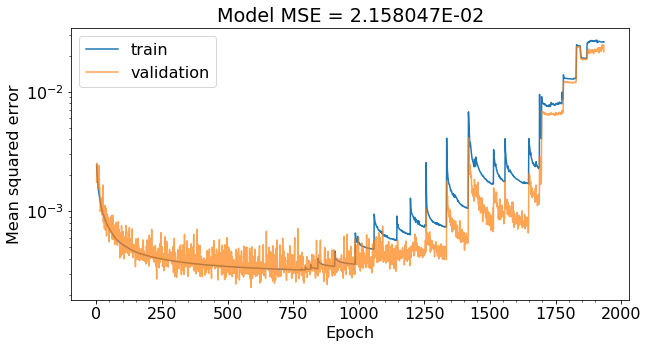

In [45]:
plt.rcParams.update({'font.size': 16})
plot_model_history_fromDict(historyDict)


for vline in vlines:
    plt.vlines(vline+1, ymin = 0, ymax = historyDict["mean_squared_error"][0], alpha = 0.5, linewidth = 0.9)

plt.ylim(10**-3.7, 10**-1.1)
plt.title("")

for jj in [0,7,9, 10,12, 14,16,18, 19]:
    s = str(np.round(cutPercent[jj+1]*2, 2)) + "%"
    plt.plot(vlines[jj], 10**-1.75, "v", color = "black")
    plt.text(vlines[jj], 10**-1.75, s,{'ha': 'left', 'va': 'bottom'}, fontsize=14, rotation=45)
plt.savefig(os.path.join(figDir, "ModelPruning_" + modelName + ".pdf"), bbox_inches='tight')
plt.show()

In [61]:
## Reload model with 80% of connections pruned and evaluate error

In [62]:
K.clear_session()


modelName =  "Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_01_27__01_30_06572_Pruned"
modeltimestamp = "2020_01_27__01_30_06"
model = load_model(os.path.join(savedModels, modelSubdir,  modelName + ".h5"))

In [63]:
wts = model.get_weights()
# print nonzero weights
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts, "of", np.sum(wtLengths), "weights retained")

63844 of 331735 weights retained


In [64]:
1 - nzwts / np.sum(wtLengths)

0.8075451791339473

In [65]:
numCuts = 7

cutPercent[numCuts]*2

80.75689165786144

In [66]:
for ii in range(10):
    history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                        verbose = 2, batch_size=2**12, epochs = 1)

    # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
    # get nonzero weights
    wts = model.get_weights().copy()

    # set weights close to 0 to 0 (but ignore biases)
    for ii in np.arange(0, len(wts), 1):
        qants = np.percentile(np.reshape(wts[ii], -1), 
                              q = (50 - cutPercent[numCuts], 
                                   50 + cutPercent[numCuts]), )
        wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

    # print nonzero weights
    # calculate number of nonzero weights
    nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
    print(nzwts, "of", np.sum(wtLengths), "weights retained")

    # set new weights and calculate new loss
    model.set_weights(wts)

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 18s - loss: 3.5564e-04 - mean_squared_error: 3.5564e-04 - val_loss: 3.5079e-04 - val_mean_squared_error: 3.5079e-04
63844 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 17s - loss: 3.5554e-04 - mean_squared_error: 3.5554e-04 - val_loss: 3.6186e-04 - val_mean_squared_error: 3.6186e-04
63844 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 17s - loss: 3.5530e-04 - mean_squared_error: 3.5530e-04 - val_loss: 3.6601e-04 - val_mean_squared_error: 3.6601e-04
63844 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 17s - loss: 3.5575e-04 - mean_squared_error: 3.5575e-04 - val_loss: 2.5863e-04 - val_mean_squared_error: 2.5863e-04
63844 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 17s - loss: 3.5517e-04 - mean_squared_error: 3.5517e-04 - val_loss: 4

In [67]:
model.evaluate(Xval_scaled, Yval_scaled)

2000000/2000000 [==============================] - 59s 30us/step


[0.0009208869594410062, 0.0009208869594410062]

In [68]:
model.evaluate(Xtrain_scaled, Ytrain_scaled)

8000000/8000000 [==============================] - 247s 31us/step


[0.0009208033409710042, 0.0009208033409710042]

In [69]:
# predict on test set
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(Ytest, columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,Fx_pred,Fy_pred,tau_pred,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred
0,-5342.432439,14670.842555,-57718.558932,-577.070011,-1317.410003,-76.817401,-84.515766,-5967.453613,17690.990234,-48919.882812,-580.231506,-1343.035034,-114.036430,-118.226456
1,-2515.747661,3418.036434,-64775.342625,-18.839022,1292.672193,17.808851,1.199298,-5309.352539,5041.308105,-60412.925781,-1.199094,1383.986938,-4.115515,-8.734145
2,-6497.950980,-17669.503572,-49237.798014,-1094.713883,-1469.532303,124.939700,115.462788,-10475.754883,-16107.546875,-47557.539062,-1136.972900,-1391.377197,144.275894,139.078659
3,24237.433019,-8489.629561,56490.932254,-187.441953,-427.573908,100.329900,100.827942,22148.250000,-6499.242676,67265.007812,-273.286438,-550.424805,135.582123,130.418793
4,1782.839206,5791.542006,26503.920442,625.069923,31.217768,-26.216617,-20.827598,3927.504150,6896.766113,32134.501953,647.107727,-55.471333,9.455336,4.783791


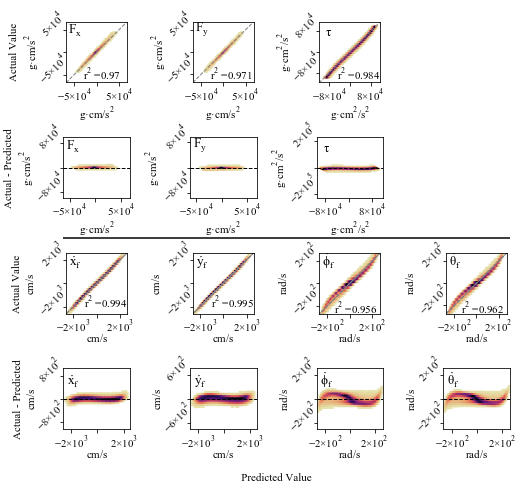

In [70]:
# make plots
from sklearn.metrics import r2_score
from matplotlib import ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 11})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.transforms as mtrans


fig_col_names = [r'$F_x$', r'$F_y$', r'$\tau$', r'$\dot{x}_f$', r'$\dot{y}_f$', r'$\dot{\phi}_f$', r'$\dot{\theta}_f$']

plt.close("all")
fig, axs = plt.subplots(4,4, figsize=np.array([8, 7.5]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.9, wspace=.9)
# fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r'$g·cm/s^2$', "$g·cm/s^2$", "$g·cm^2/s^2$", "$cm/s$", "$cm/s$", "$rad/s$", "$rad/s$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
# make really low-value hexbins white
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, 3):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].set_yticklabels(axs[ii].get_yticklabels(), 
                            rotation = 45, ha="center",
                            va = "bottom", rotation_mode="anchor")
    axs[ii].yaxis.set_label_coords(-0.4,0.5)
    axs[ii].set_xlabel(ylabs[ii] + "\n")
    axs[ii].xaxis.set_label_coords(0.5,-0.3)
    axs[ii].tick_params(axis="x",direction="out", pad=-0)
    

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].set_title(fig_col_names[ii], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[ii].title
    ttl.set_position([.15, 0.62])
    
    # draw identity lines
    lims = [
        np.min([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # min of both axes
        np.max([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # max of both axes
        ]
    axs[ii].plot(lims, lims,  
                 'grey', linewidth = 1, linestyle  = "--")
#     axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
#                  df_c.loc[:,YtestDF.columns[ii]], 
#                  'grey', linewidth = 1, linestyle  = "--")
    axs[ii].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].set_aspect('equal', 'box')

    # annotate with R^2
    axs[ii].text(np.max(lims)*-0.4, 
                 np.min(lims)*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])
    axs[ii].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(4, 7)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.3)
    
    if jj == 3:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                      Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])
        
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.62])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
#####
#### Part 2
#####

#fig.subplots_adjust(hspace = 0.9, wspace=.9)

# Plot y = actual, x = predicted
for plotnum, dataColNum in zip(np.arange(8,12), np.arange(3, 7)):
    axs[plotnum].hexbin(y = df_c.loc[:,YtestDF.columns[dataColNum]],
                   x = df_c.loc[:,YpredDF.columns[dataColNum]], 
                   gridsize = 50, cmap = cmap)
    axs[plotnum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].set_yticklabels(axs[plotnum].get_yticklabels(),
                                 rotation = 45, ha="center",
                                 va = "bottom", rotation_mode="anchor")
    axs[plotnum].yaxis.set_label_coords(-0.5,0.5)
    axs[plotnum].set_xlabel(ylabs[dataColNum] + "\n")
    axs[plotnum].xaxis.set_label_coords(0.5,-0.3)

    if(plotnum == 8):
        axs[plotnum].set_ylabel("Actual Value\n" + ylabs[dataColNum])
    else:
        axs[plotnum].set_ylabel(ylabs[dataColNum])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[plotnum].set_title(fig_col_names[dataColNum], 
                           fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotnum].title
    ttl.set_position([.15, 0.60])
    axs[plotnum].plot(df_c.loc[:,YtestDF.columns[dataColNum]], 
                 df_c.loc[:,YtestDF.columns[dataColNum]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[plotnum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].set_aspect('equal', 'box')

    # annotate with R^2
    axs[plotnum].text(np.max(df_c.loc[:,YtestDF.columns[dataColNum]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[dataColNum]])*0.75, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[dataColNum]],  
                                        df_c.loc[:,YpredDF.columns[dataColNum]])), 3)))
    axs[plotnum].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    axs[plotnum].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    
    axs[plotnum].tick_params(axis="x",direction="out", pad=-0)

# residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
# refref Here
for jj, plotNum in zip(np.arange(3, 7), np.arange(12, 16)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.3)############################
    
    if jj == 4:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                                       Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 3):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.55])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
    
axs[3].axis('off')
axs[7].axis('off')

# add black horizontal line
ax3 = plt.figure(1).add_subplot(111)
ax3.plot([-1,1],[0.47,0.47], '-', color = "black" )
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.axis("off")

#plt.tight_layout()
fig.savefig(os.path.join(figDir, "PredVActual" + modelName + "PRUNED.pdf"),)
plt.show()
# plt.close()

In [71]:
np.max(df_c.loc[:,"Fy"] - df_c.loc[:,"Fy_pred"])

90125.91557855174

In [72]:
np.max( df_c.loc[:,"Fy_pred"])

68017.96

In [73]:
np.max( df_c.loc[:,"Fy"])

44299.234220458886